In [1]:
# # shihtl> For Colab environment
# !pip install torchmetrics
# !pip install datasets==2.21.0

In [2]:
# # shihtl> For Colab environment
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import transformers as T
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from torchmetrics import SpearmanCorrCoef, Accuracy, F1Score
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import gc
device = "cuda:0" if torch.cuda.is_available() else "cpu"

c:\Tsung\Programming\GitHub\11310CS563100_Assignments\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# shihtl> Code ref: https://blog.csdn.net/u014687517/article/details/94719910
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(814750857)
# shihtl> Section end.

In [5]:
# 有些中文的標點符號在tokenizer編碼以後會變成[UNK]，所以將其換成英文標點
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [6]:
model_name = "google-bert/bert-base-uncased"
tokenizer = T.BertTokenizer.from_pretrained(model_name, cache_dir="./cache/")

In [7]:
class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation", "test"]
        self.data = load_dataset(
            "sem_eval_2014_task_1",
            split=split,
            cache_dir="./cache/",
            trust_remote_code=True,
        ).to_list()

    def __getitem__(self, index):
        d = self.data[index]
        # 把中文標點替換掉
        for k in ["premise", "hypothesis"]:
            for tok in token_replacement:
                d[k] = d[k].replace(tok[0], tok[1])
        return d

    def __len__(self):
        return len(self.data)


data_sample = SemevalDataset(split="train").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")
data_sample = SemevalDataset(split="validation").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")
data_sample = SemevalDataset(split="test").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")

Dataset example: 
{'sentence_pair_id': 1, 'premise': 'A group of kids is playing in a yard and an old man is standing in the background', 'hypothesis': 'A group of boys in a yard is playing and a man is standing in the background', 'relatedness_score': 4.5, 'entailment_judgment': 0} 
{'sentence_pair_id': 2, 'premise': 'A group of children is playing in the house and there is no man standing in the background', 'hypothesis': 'A group of kids is playing in a yard and an old man is standing in the background', 'relatedness_score': 3.200000047683716, 'entailment_judgment': 0} 
{'sentence_pair_id': 3, 'premise': 'The young boys are playing outdoors and the man is smiling nearby', 'hypothesis': 'The kids are playing outdoors near a man with a smile', 'relatedness_score': 4.699999809265137, 'entailment_judgment': 1}
Dataset example: 
{'sentence_pair_id': 4, 'premise': 'The young boys are playing outdoors and the man is smiling nearby', 'hypothesis': 'There is no boy playing outdoors and there

In [8]:
# Define the hyperparameters
lr = 3e-5
epochs = 10
train_batch_size = 8
validation_batch_size = 128

In [9]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.

def collate_fn(batch):
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    # Use tokenizer to pack tokenize and pack the data and its corresponding labels.
    # Return the data batch and labels for each sub-task.
    premise_batch = [data["premise"] for data in batch]
    hypothesis_batch = [data["hypothesis"] for data in batch]

    batch_result = tokenizer(premise_batch, hypothesis_batch, truncation=True, padding=True)
    for k, v in batch_result.items():
        batch_result[k] = torch.tensor(v).to(device)

    relatedness_score = torch.tensor([data["relatedness_score"] for data in batch]).to(device)
    entailment_judgment = torch.tensor([data["entailment_judgment"] for data in batch]).to(device)

    return batch_result, relatedness_score, entailment_judgment

# TODO1-2: Define your DataLoader
dl_train = DataLoader(SemevalDataset("train"), batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
dl_validation = DataLoader(SemevalDataset("validation"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn)
dl_test = DataLoader(SemevalDataset("test"), batch_size=validation_batch_size, shuffle=False, collate_fn=collate_fn)
# dl_train = DataLoader(SemevalDataset("train").data[:8], batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
# dl_validation = DataLoader(SemevalDataset("validation").data[:8], batch_size=validation_batch_size, shuffle=True, collate_fn=collate_fn)
# dl_test = DataLoader(SemevalDataset("test").data[:8], batch_size=validation_batch_size, shuffle=True, collate_fn=collate_fn)

res = next(iter(dl_train))
print(res[0].keys())
print(res)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
({'input_ids': tensor([[  101,  1037,  9081,  3203,  2003,  2559,  2012,  1037,  3578,   102,
          1037,  2450,  2003,  2559,  2012,  1996,  3193,  1997,  1037,  2103,
           102,     0,     0,     0,     0,     0],
        [  101,  2070,  3869,  2024,  5742,   102,  1037,  3869,  2003,  5742,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  1037,  2177,  1997,  4004,  3057,  2024,  3061,  2362,   102,
          1996,  2177,  1997,  4004,  3057,  2024,  3061,  2362,   102,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  1037,  9092,  3899,  2003,  8660,  2039,  1998,  9105,  1037,
          5093,  3608,   102,  2045,  2003,  2053,  9092,  3899,  8660,  2039,
          1998,  9105,  1037,  5093,  3608,   102],
        [  101,  1037,  2312,  2317, 11308,  2003,  3909,  2379,  1996,  2300,
     

In [10]:
print(tokenizer.vocab["[CLS]"])
print(tokenizer.vocab["[SEP]"])

101
102


In [11]:
def logits_to_prediction(logits):
    return np.argmax(logits.cpu(), axis=1)

sample_logits = torch.tensor([[1, 2, 3], [0, 5, 1], [9, 0, 0]])
logits_to_prediction(sample_logits)

tensor([2, 1, 0])

In [12]:
# shihtl> model1: vanilla model
# TODO2: Construct your model
class MultiLabelModel1(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=3),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data = self.bert.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data)

        return ans1, ans2

In [13]:
# shihtl> model2: two linear layers model
# TODO2: Construct your model
class MultiLabelModel2(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=3),
            torch.nn.Sigmoid(),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data = self.bert.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data)

        return ans1, ans2

In [14]:
# shihtl> model3: model2 + dropout 0.1 model
# TODO2: Construct your model
class MultiLabelModel3(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=3),
            torch.nn.Sigmoid(),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data = self.bert.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data)

        return ans1, ans2

In [15]:
# shihtl> model4: model3 + common layer model
# TODO2: Construct your model
class MultiLabelModel4(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.common_layer = torch.nn.Linear(
            in_features=self.bert.config.hidden_size,
            out_features=self.bert.config.hidden_size,
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=3),
            torch.nn.Sigmoid(),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data = self.bert.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl>
        data = self.common_layer.forward(data)
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data)

        return ans1, ans2

In [16]:
# shihtl> model5: model4 + another common layer model
# TODO2: Construct your model
class MultiLabelModel5(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.common_layer1 = torch.nn.Linear(
            in_features=self.bert.config.hidden_size,
            out_features=self.bert.config.hidden_size,
        )
        self.common_layer2 = torch.nn.Linear(
            in_features=256,
            out_features=256,
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            self.common_layer2,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            self.common_layer2,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=3),
            torch.nn.Sigmoid(),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data = self.bert.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl>
        data = self.common_layer1.forward(data)
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data)

        return ans1, ans2

In [17]:
# shihtl> model6: two bert model
# TODO2: Construct your model
class MultiLabelModel6(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert_reg = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )
        self.bert_hypo = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert_reg.config.hidden_size, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert_hypo.config.hidden_size, out_features=3),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data_reg = self.bert_reg.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        data_hypo = self.bert_hypo.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data_reg)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data_hypo)

        return ans1, ans2

In [18]:
# shihtl> model7: model5 + more dim in second common layer model
# TODO2: Construct your model
class MultiLabelModel7(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.common_layer1 = torch.nn.Linear(
            in_features=self.bert.config.hidden_size,
            out_features=self.bert.config.hidden_size,
        )
        self.common_layer2 = torch.nn.Linear(
            in_features=768,
            out_features=768,
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=768),
            torch.nn.ReLU(),
            self.common_layer2,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=768, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=768),
            torch.nn.ReLU(),
            self.common_layer2,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=768, out_features=3),
            torch.nn.Sigmoid(),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data = self.bert.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl>
        data = self.common_layer1.forward(data)
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data)

        return ans1, ans2

In [17]:
# shihtl> model8: model3 + more layer
# TODO2: Construct your model
class MultiLabelModel8(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.AutoModelForSequenceClassification.from_pretrained(
            model_name, cache_dir="./cache/", output_hidden_states=True
        )

        self.regression = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=1),
        )  # shihtl> regression task

        self.classificaton = torch.nn.Sequential(
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(in_features=self.bert.config.hidden_size, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=3),
            torch.nn.Sigmoid(),
        )  # shihtl> classification task

    def forward(self, batch_dict):
        # Write your code here
        # Forward pass
        # shihtl> [CLS] label's hidden states
        data = self.bert.forward(
            input_ids=batch_dict["input_ids"],
            attention_mask=batch_dict["attention_mask"],
        ).hidden_states[-1][:, 0, :]
        # shihtl> ans1.shape = (batch_size, 1), the regression result
        ans1 = self.regression.forward(data)
        # shihtl> ans2.shape = (batch_size, num_of_classes), the logits of classification
        ans2 = self.classificaton.forward(data)

        return ans1, ans2

In [ ]:
# shihtl> For report data collection
records = {}

def model_train_and_valid(model_class):
    model = model_class().to(device)

    # TODO3: Define your optimizer and loss function
    # TODO3-1: Define your Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)
    # TODO3-2: Define your loss functions (you should have two)
    # Write your code here
    criterion_premise = torch.nn.MSELoss()
    criterion_hypo = torch.nn.CrossEntropyLoss()

    # scoring functions
    spc = SpearmanCorrCoef().to(device)
    acc = Accuracy(task="multiclass", num_classes=3).to(device)
    f1 = F1Score(task="multiclass", num_classes=3, average="macro").to(device)

    for ep in range(epochs):
        PARAM = f"{model.__class__.__name__}_ep{ep}_lr{lr}_bs{train_batch_size}"
        print(f" {PARAM} ".center(100, "="))
        record = {}

        loss_record_combined = []
        loss_record_reg = []
        loss_record_class = []

        pbar = tqdm(dl_train)
        pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
        model.train()
        # TODO4: Write the training loop
        # Write your code here
        # train your model
        for batch_dict, relatedness_score, entailment_judgment in pbar:
            # clear gradient
            optimizer.zero_grad()
            # forward pass
            output1, output2 = model(batch_dict)
            # compute loss
            premise_loss = criterion_premise(output1.squeeze(), relatedness_score)
            hypo_loss = criterion_hypo(output2, entailment_judgment)
            # back-propagation
            loss = premise_loss + hypo_loss
            loss.backward()
            # model optimization
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
            loss_record_combined.append(loss.item())
            loss_record_reg.append(premise_loss.item())
            loss_record_class.append(hypo_loss.item())

        # # shihtl> Draw training loss
        # plt.figure(figsize=(4, 3))
        # plt.xlabel("Epoch")
        # plt.ylabel("Training Loss (Combined)")
        # plt.plot(loss_record_combined)
        # plt.show()

        pbar = tqdm(dl_validation)
        pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
        model.eval()
        # TODO5: Write the evaluation loop
        # Write your code here
        # Evaluate your model
        with torch.no_grad():
            all_output1 = []
            all_output2 = []
            all_relatedness_score = []
            all_entailment_judgment = []

            for batch_dict, relatedness_score, entailment_judgment in pbar:
                output1, output2 = model(batch_dict)

                all_output1.append(output1)
                all_output2.append(output2)
                all_relatedness_score.append(relatedness_score)
                all_entailment_judgment.append(entailment_judgment)

        all_output1 = torch.vstack(all_output1)
        all_output2 = torch.vstack(all_output2)
        all_relatedness_score = torch.cat(all_relatedness_score)
        all_entailment_judgment = torch.cat(all_entailment_judgment)

        # Output all the evaluation scores (SpearmanCorrCoef, Accuracy, F1Score)
        spearman = spc(all_output1.squeeze(), all_relatedness_score).item()
        print(f"Spearman Corr: {spearman}")
        accuracy = acc(all_output2, all_entailment_judgment).item()
        print(f"Accuracy: {accuracy}")
        f1_score = f1(all_output2, all_entailment_judgment).item()
        print(f"F1 Score: {f1_score}\n")

        # shihtl> Get predict labels from logits
        pred_value = logits_to_prediction(all_output2)
        confusion = confusion_matrix(all_entailment_judgment.cpu(), pred_value.cpu())

        # torch.save(model, f"./saved_models/{PARAM}.ckpt")

        record["loss_record_combined"] = loss_record_combined
        record["loss_record_reg"] = loss_record_reg
        record["loss_record_class"] = loss_record_class
        record["spearman"] = spearman
        record["accuracy"] = accuracy
        record["f1_score"] = f1_score
        record["confusion"] = confusion

        records[PARAM] = record

        # shihtl> This section of code was generated by GPT-4o in Assignment 2, and modified to fit Assignment 3.
        # save the record
        with open(f"./all_records_8.pkl", "wb") as f:
        # with open(f"drive/MyDrive/university_files/11310_NLP/all_records.pkl", "wb") as f:
            pickle.dump(records, f)
        # shihtl> Section end.

    # shihtl> Testing
    record = {}
    PARAM = f"{model.__class__.__name__}_lr{lr}_bs{train_batch_size}"
    print(f" [TEST] {PARAM} ".center(100, "="))
    pbar = tqdm(dl_test)
    pbar.set_description(f"Testing epoch [{ep+1}/{epochs}]")
    model.eval()
    # Write your code here
    # Evaluate your model
    with torch.no_grad():
        all_output1 = []
        all_output2 = []
        all_relatedness_score = []
        all_entailment_judgment = []

        for batch_dict, relatedness_score, entailment_judgment in pbar:
            output1, output2 = model(batch_dict)

            all_output1.append(output1)
            all_output2.append(output2)
            all_relatedness_score.append(relatedness_score)
            all_entailment_judgment.append(entailment_judgment)

    all_output1 = torch.vstack(all_output1)
    all_output2 = torch.vstack(all_output2)
    all_relatedness_score = torch.cat(all_relatedness_score)
    all_entailment_judgment = torch.cat(all_entailment_judgment)

    # Output all the evaluation scores (SpearmanCorrCoef, Accuracy, F1Score)
    spearman = spc(all_output1.squeeze(), all_relatedness_score).item()
    print(f"Spearman Corr: {spearman}")
    accuracy = acc(all_output2, all_entailment_judgment).item()
    print(f"Accuracy: {accuracy}")
    f1_score = f1(all_output2, all_entailment_judgment).item()
    print(f"F1 Score: {f1_score}\n")

    # shihtl> Get predict labels from logits
    pred_value = logits_to_prediction(all_output2)
    confusion = confusion_matrix(all_entailment_judgment.cpu(), pred_value.cpu())

    # torch.save(model, f"./saved_models/{PARAM}.ckpt")
    torch.save(model, f'./saved_models/ep{ep}.ckpt')

    record["loss_record_combined"] = loss_record_combined
    record["loss_record_reg"] = loss_record_reg
    record["loss_record_class"] = loss_record_class
    record["spearman"] = spearman
    record["accuracy"] = accuracy
    record["f1_score"] = f1_score
    record["confusion"] = confusion

    records[PARAM] = record

    # shihtl> This section of code was generated by GPT-4o in Assignment 2, and modified to fit Assignment 3.
    # save the record
    with open(f"./all_records.pkl", "wb") as f:
    # with open(f"drive/MyDrive/university_files/11310_NLP/all_records.pkl", "wb") as f:
        pickle.dump(records, f)
    # shihtl> Section end.
    # shihtl> Testing end.

    model.cpu()
    del model

for model_class in [
    MultiLabelModel3,
]:
    model_train_and_valid(model_class)

    # shihtl> Prevent GPU out of memory.
    gc.collect()
    torch.cuda.empty_cache()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Tsung\Programming\GitHub\11310CS563100_Assignments\venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


================================= MultiLabelModel8_ep0_lr3e-05_bs8 =================================


Training epoch [1/10]:   0%|          | 0/563 [00:00<?, ?it/s]c:\Tsung\Programming\GitHub\11310CS563100_Assignments\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Validation epoch [1/10]: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Spearman Corr: 0.7380977869033813
Accuracy: 0.6639999747276306
F1 Score: 0.4637985825538635

================================= MultiLabelModel8_ep1_lr3e-05_bs8 =================================


Validation epoch [2/10]: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


Spearman Corr: 0.8011645674705505
Accuracy: 0.8420000076293945
F1 Score: 0.8439143896102905

================================= MultiLabelModel8_ep2_lr3e-05_bs8 =================================


Validation epoch [3/10]: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Spearman Corr: 0.821016788482666
Accuracy: 0.8579999804496765
F1 Score: 0.8532532453536987

================================= MultiLabelModel8_ep3_lr3e-05_bs8 =================================


Validation epoch [4/10]: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Spearman Corr: 0.8184088468551636
Accuracy: 0.8560000061988831
F1 Score: 0.8522351980209351

================================= MultiLabelModel8_ep4_lr3e-05_bs8 =================================


Validation epoch [5/10]: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Spearman Corr: 0.8146349191665649
Accuracy: 0.8539999723434448
F1 Score: 0.8523787260055542

================================= MultiLabelModel8_ep5_lr3e-05_bs8 =================================


Validation epoch [6/10]: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Spearman Corr: 0.8079681992530823
Accuracy: 0.8379999995231628
F1 Score: 0.8409783840179443

================================= MultiLabelModel8_ep6_lr3e-05_bs8 =================================


Validation epoch [7/10]: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Spearman Corr: 0.8218713402748108
Accuracy: 0.8479999899864197
F1 Score: 0.8445683717727661

================================= MultiLabelModel8_ep7_lr3e-05_bs8 =================================


Validation epoch [8/10]: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Spearman Corr: 0.829389750957489
Accuracy: 0.8679999709129333
F1 Score: 0.8689318895339966

================================= MultiLabelModel8_ep8_lr3e-05_bs8 =================================


Validation epoch [9/10]: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Spearman Corr: 0.8052844405174255
Accuracy: 0.8539999723434448
F1 Score: 0.847387433052063

================================= MultiLabelModel8_ep9_lr3e-05_bs8 =================================


Validation epoch [10/10]: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Spearman Corr: 0.8189677596092224
Accuracy: 0.8579999804496765
F1 Score: 0.8566935062408447

=============================== [TEST] MultiLabelModel8_lr3e-05_bs8 ================================


Testing epoch [10/10]: 100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Spearman Corr: 0.8164324760437012
Accuracy: 0.865841269493103
F1 Score: 0.8612554669380188



For test set predictions, you can write perform evaluation simlar to #TODO5.

In [19]:
import pandas as pd


model3 = torch.load("./saved_models/MultiLabelModel3_lr3e-05_bs8.ckpt", weights_only=False)
model3.eval()

pbar = tqdm(dl_test)
pbar.set_description(f"Testing")
# Write your code here
# Evaluate your model
with torch.no_grad():
    all_output1 = []
    all_output2 = []
    all_relatedness_score = []
    all_entailment_judgment = []

    for batch_dict, relatedness_score, entailment_judgment in pbar:
        output1, output2 = model3(batch_dict)

        all_output1.append(output1)
        all_output2.append(output2)
        all_relatedness_score.append(relatedness_score)
        all_entailment_judgment.append(entailment_judgment)

all_output1 = torch.vstack(all_output1).cpu()
all_output2 = torch.vstack(all_output2).cpu()
all_relatedness_score = torch.cat(all_relatedness_score).cpu()
all_entailment_judgment = torch.cat(all_entailment_judgment).cpu()

spc = SpearmanCorrCoef()
acc = Accuracy(task="multiclass", num_classes=3)
f1 = F1Score(task="multiclass", num_classes=3, average="macro")

# Output all the evaluation scores (SpearmanCorrCoef, Accuracy, F1Score)
spearman = spc(all_output1.squeeze(), all_relatedness_score).item()
print(f"Spearman Corr: {spearman}")
accuracy = acc(all_output2, all_entailment_judgment).item()
print(f"Accuracy: {accuracy}")
f1_score = f1(all_output2, all_entailment_judgment).item()
print(f"F1 Score: {f1_score}\n")

# shihtl> Get predict labels from logits
pred_value = logits_to_prediction(all_output2)
confusion = confusion_matrix(all_entailment_judgment.cpu(), pred_value.cpu())

df = pd.DataFrame(SemevalDataset(split="test").data)
df["pred_relatedness_score"] = all_output1
df["pred_entailment_judgment"] = pred_value

df_class_wrong = df.loc[(df["entailment_judgment"] != df["pred_entailment_judgment"])]

Testing:   0%|          | 0/39 [00:00<?, ?it/s]c:\Tsung\Programming\GitHub\11310CS563100_Assignments\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Testing: 100%|██████████| 39/39 [00:19<00:00,  2.04it/s]
c:\Tsung\Programming\GitHub\11310CS563100_Assignments\venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Spearman Corr: 0.8229601383209229
Accuracy: 0.8696975708007812
F1 Score: 0.8630536794662476



In [20]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_colwidth", 100)
df_class_wrong = df.loc[(df["entailment_judgment"] != df["pred_entailment_judgment"])]
# for row in df_class_wrong[["premise", "hypothesis", "entailment_judgment", "pred_entailment_judgment"]].head().iterrows():
#     for ele in row:
#         print(ele)

ddd = df_class_wrong[["premise", "hypothesis", "entailment_judgment", "pred_entailment_judgment"]].head()

C:\Users\X6959\AppData\Local\Temp\ipykernel_41036\4181757502.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\X6959\AppData\Local\Temp\ipykernel_41036\4181757502.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


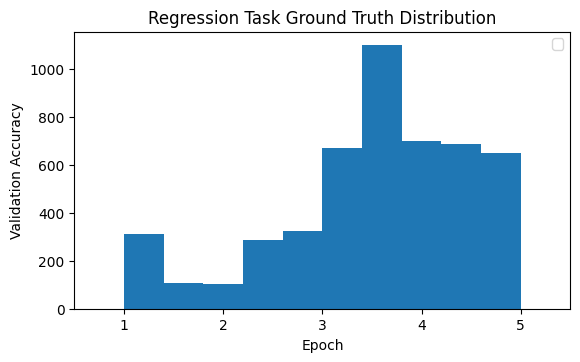

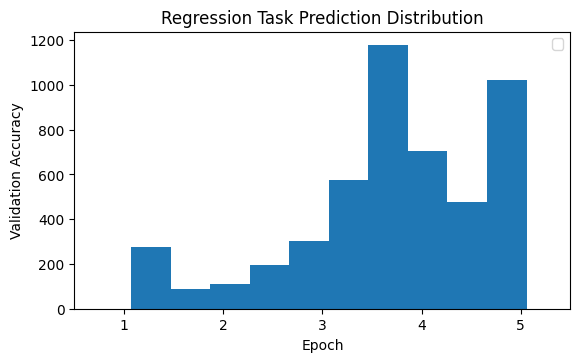

In [28]:
title = "Regression Task Ground Truth Distribution"
plt.figure(figsize=(16 / 2.5, 9 / 2.5))

y = df[["relatedness_score"]]

plt.hist(y)
plt.xlim(xmin=0.5, xmax=5.5)

plt.legend()
plt.title(title, fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.savefig(title + ".png", bbox_inches="tight")

title = "Regression Task Prediction Distribution"
plt.figure(figsize=(16 / 2.5, 9 / 2.5))

y = df[["pred_relatedness_score"]]

plt.hist(y)
plt.xlim(xmin=0.5, xmax=5.5)

plt.legend()
plt.title(title, fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.savefig(title + ".png", bbox_inches="tight")